In [35]:
from pathlib import Path
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

import sys
sys.path.insert(0,"abetam")
from abetam.figures import sciencify_plotly_fig

def copper_result_dir(abm_result_dir: Path):
    scen_date, iteration = abm_result_dir.stem.rsplit("_",1)
    result_dirs = list(Path(f"copper/results/{scen_date}").iterdir())
    result_dirs = sorted(result_dirs)
    return result_dirs[int(iteration)]

abm_result_dirs = Path("results").iterdir()
date = "20240513"
abm_result_dirs = [d for d in abm_result_dirs if date in d.name]
# abm_result_dirs
result_df = pd.DataFrame(list([(d, copper_result_dir(d)) for d in sorted(abm_result_dirs)]), columns=["ABM path", "ESM path"])
result_df["iteration"] = result_df["ABM path"].apply( lambda p: p.stem.rsplit("_",1)[-1]).astype(int)

result_df["Scenario"] = result_df["ABM path"].apply( lambda p: p.stem.split("_",1)[0])

scen_mod = result_df["ABM path"].apply(lambda p: "+" if "_plus" in p.stem else "")

result_df["Scenario"] = result_df["Scenario"] + scen_mod

result_df

,ABM path,ESM path,iteration,Scenario
0,results\BAU_20240513_0711_0,copper\results\BAU_20240513_0711\BAU_scenario_...,0,BAU
1,results\BAU_20240513_0711_1,copper\results\BAU_20240513_0711\BAU_scenario_...,1,BAU
2,results\BAU_20240513_0711_2,copper\results\BAU_20240513_0711\BAU_scenario_...,2,BAU
3,results\BAU_20240513_0711_3,copper\results\BAU_20240513_0711\BAU_scenario_...,3,BAU
4,results\BAU_20240513_0711_4,copper\results\BAU_20240513_0711\BAU_scenario_...,4,BAU


## Demand analysis

In [36]:
from main import add_abm_demand_to_projection
from abetam.batch import BatchResult


demands = []
for i,row in result_df[["ABM path", "iteration"]].iterrows():#
    abm_res_path, iteration = row["ABM path"], row["iteration"]
    b_res = BatchResult.from_directory(abm_res_path)
    model_demand = b_res.mean_carrier_demand_df
    new_demand = add_abm_demand_to_projection(model_demand)
    abm_inkl_peaks = new_demand.max().reset_index()
    abm_inkl_peaks[["province","year"]] = abm_inkl_peaks["index"].str.split(".",expand=True)
    abm_inkl_peaks = abm_inkl_peaks.rename({0:"ABM_incl"}, axis=1).drop(["index","province"],axis=1)
    abm_inkl_peaks["Demand"] = "ABM it. no: " + str(iteration)
    demands.append(abm_inkl_peaks)

abm_demands = pd.concat(demands)

In [50]:
from main import spread_model_demand

pd_demand = b_res.mean_carrier_demand_df["Electricity"].to_frame().reset_index().pivot(columns=["year"], index="hour")["Electricity"]
pd_demand.columns = [f"Ontario.{str(int(col))}" for col in pd_demand.columns]
px.line(spread_model_demand(pd_demand))

c:\Users\dhuck\miniconda3\envs\cando\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [ ]:
abm_demands.columns = ["value", "year", "Demand source"]

In [ ]:
copper_demand_projection = pd.read_csv("copper/scenarios/BAU_scenario/copper_demand_user_demand=False.csv")
copper_demand_projection.columns = ["year","hour"] + copper_demand_projection.columns[2:].to_list()
copper_demand_projection["Ontario"] = copper_demand_projection["Ontario.a"] + copper_demand_projection["Ontario.b"]

copper_demand_peaks = copper_demand_projection.groupby(["year"]).max()["Ontario"].reset_index()
copper_demand_peaks = copper_demand_peaks.rename({"Ontario":"COPPER projection"}, axis=1)
copper_demand_peaks_long = copper_demand_peaks.melt(id_vars="year")
copper_demand_peaks_long.columns = ["year", "Demand source", "value"]

In [ ]:
fig = sciencify_plotly_fig(
    px.line(
        pd.concat([abm_demands, copper_demand_peaks_long]),
        x="year",
        y="value",
        color="Demand source",
        template="plotly",
    )
)
fig.update_layout(yaxis_title="Peak demand (MW)", width=400)


In [ ]:
for i,row in result_df[["ESM path", "iteration"]].iterrows():#
    esm_res_path, iteration = row["ABM path"], row["iteration"]

    abm_inkl_peaks = new_demand.max().reset_index()
    abm_inkl_peaks[["province","year"]] = abm_inkl_peaks["index"].str.split(".",expand=True)
    abm_inkl_peaks = abm_inkl_peaks.rename({0:"ABM_incl"}, axis=1).drop(["index","province"],axis=1)
    abm_inkl_peaks["Demand"] = "ABM it. no: " + str(iteration)
    demands.append(abm_inkl_peaks)

In [ ]:
from copper.phases.postprocessing import get_all_supply

supply_df = get_all_supply(result_df["ESM path"][0])
supply_df.groupby(["pds","h"]).sum().groupby("pds").max()

In [ ]:
import sys 
sys.path.insert(0,"abetam")
from abetam.batch import BatchResult
import seaborn as sns
from abetam.data.canada import (
    uncertain_demand_from_income_and_province,
    get_end_use_agg_heating_share
)
from abetam.components.model import get_income_and_attitude_weights
from abetam.components.technologies import merge_heating_techs_with_share
from abetam.batch import transform_dict_column

def get_demand_reductions(n):
    dem_red = np.random.normal(0.4875, 0.125, n)
    # ensure (0,1) boundaries
    dem_red[dem_red < 0] = -dem_red[dem_red < 0]
    dem_red[dem_red > 1] = 1 - (dem_red[dem_red > 1] - 1)
    return dem_red

def mean_energy_demand(n):
    province = "Ontario"
    price_weight_mode = 0.55
    start_year=2020
    income_distribution, weights_df = get_income_and_attitude_weights(
        n, price_weight_mode=price_weight_mode
    )
    total_energy_demand = uncertain_demand_from_income_and_province(
        income_distribution, province
    )

    province_heat_share = get_end_use_agg_heating_share(province, start_year)
    heat_demand = total_energy_demand * province_heat_share
    return heat_demand.mean()

def get_scenario_retrofit_cost(abm_res):
    no_refurbishments = abm_res.results_df[["RunId","AgentID","Refurbished","Heat demand"]].drop_duplicates().groupby("RunId")["Refurbished"].sum()
    assert no_refurbishments[0] == no_refurbishments.mean()

    mean_demand = mean_energy_demand(no_refurbishments[0])
    demand_frame = abm_res.results_df[["RunId","Step","AgentID","Heat demand"]].query("Step == 0")
    demand_frame["n_households"] = demand_frame["Heat demand"]/mean_demand
    demand_frame = demand_frame.groupby("RunId").sum()
    seeds = abm_res.results_df[["RunId","random_seed"]].drop_duplicates().set_index("RunId")
    seeds["n_households"] = demand_frame["n_households"]
    no_res_buildings = 1639581 #https://open.canada.ca/data/en/dataset/7803173f-8ab7-428c-b987-74bbde245e12/resource/6cc8a832-11d5-4d9a-9796-397905490dc1
    no_households = 5.169*1e6 # https://www.ontario.ca/page/ontario-demographic-quarterly-highlights-first-quarter

    households_per_building = no_households/no_res_buildings

    max_build_work_cost = 100000
    total_retrofit_costs = pd.DataFrame()
    refurbished_share = no_refurbishments[0]/abm_res.results_df["AgentID"].max()
    for r_id, seed, n_households in seeds.itertuples():
        # _, r_id, seed = tupl
        np.random.seed(seed)
        dem_reds = get_demand_reductions(no_refurbishments[0])

        # assume maximum reduction == maximum cost
        dem_reds /= dem_reds.max()
        retrofit_costs = (dem_reds*max_build_work_cost).mean()*no_households*refurbished_share/households_per_building
        # print(n_households/households_per_building)

        total_retrofit_costs.at[r_id,"Retrofit costs (CAD)"] = retrofit_costs

    total_retrofit_costs["scenario"] = scenario
    return total_retrofit_costs


def abm_total_ann_cost(abm_res):
    N = abm_res.results_df["N"][0]
    start_year = abm_res.results_df["start_year"][0]
    province = abm_res.results_df["province"][0]
    assert len(abm_res.results_df["province"].unique()) < 2

    # get adoption details from result
    adopt_df = abm_res.adoption_details_df.pivot(index=["RunId","year"],columns="AgentID",values="tech")

    # get starting tech distribution
    heating_techs_df = merge_heating_techs_with_share(
        start_year=start_year, province=province
    ).reset_index()
    heating_techs_df["upper_idx"] = (heating_techs_df["cum_share"] * N).astype(int)

    starting_techs = [heating_techs_df.query(f"{i}<=upper_idx")["index"].iloc[0] for i in range(500)]
    start_tech_df = pd.DataFrame([starting_techs]*6, index=pd.MultiIndex.from_product([range(6),[2020.]], names=["RunId","year"]), columns=range(500))

    # add starting tech distribution to adoption df and forward fill the dataframe
    tech_agent_map = pd.concat([adopt_df, start_tech_df]).sort_index().ffill()

    # get annual cost lookup from result
    tech_ann_cost = abm_res.results_df[["year","RunId","AgentID","Technology annual_cost"]]
    tech_ann_cost = transform_dict_column(tech_ann_cost, "Technology annual_cost", return_cols=False)
    tech_ann_cost_lookup = tech_ann_cost.melt(id_vars=["year","RunId","AgentID"], ).set_index(["year","RunId","AgentID","variable"])

    def fill_costs(col):
        # apply called on a df yields a column as param here
        col_df = col.to_frame(name="variable")
        col_df["AgentID"] = col.name
        idx = pd.Index(col_df.reset_index()[["year","RunId","AgentID","variable"]])
        return tech_ann_cost_lookup.loc[idx, "value"].values

    # swap tech names with their annual costs
    ann_cost_agent_map = tech_agent_map.apply(fill_costs)

    # reduce to full years
    is_full_year = ann_cost_agent_map.reset_index()["year"]%1==0
    ann_cost_agent_map = ann_cost_agent_map.reset_index().loc[is_full_year,:].set_index(["RunId","year"])

    # sum
    total_abm_cost = ann_cost_agent_map.groupby(["RunId"]).sum().sum(axis=1)
    return total_abm_cost.to_frame(name="agg. annual costs")


In [ ]:


tech_share_dfs = []
fuel_demands = []
subsidy_dfs = []
emission_dfs = []
lcoh_dfs = []
spendings_dfs = []
retrofit_costs = []
abm_agg_cost = []
scenario = result_df.Scenario[0]
assert len(result_df.Scenario.unique())==1
for it in result_df.iteration.unique():
    # print(scenario,":", result_df.query(f"iteration==1 and Scenario=='{scenario}'"))
    abm_res = BatchResult.from_directory(result_df.query(f"iteration=={it} and Scenario=='{result_df.Scenario[0]}'")["ABM path"].values[0])

    scenario = result_df.Scenario[0] + "_" + str(it)

    t_share_df = abm_res.tech_shares_df
    t_share_df["scenario"] = scenario
    tech_share_dfs.append(t_share_df)

    demands = abm_res.mean_carrier_demand_df.copy()
    demands["scenario"] = scenario
    fuel_demands.append(demands)

    subs = abm_res.subsidies_df
    subs["scenario"] = scenario
    subsidy_dfs.append(subs)

    emiss = abm_res.emissions()
    emiss["scenario"] = scenario
    emission_dfs.append(emiss)

    lcohs = pd.DataFrame.from_records(abm_res.results_df["LCOH"])
    lcohs[['year','RunId','AgentID',"Refurbished"]] = abm_res.results_df[['year','RunId','AgentID',"Refurbished"]]
    long_lcohs = lcohs.set_index(["year","RunId","AgentID","Refurbished"]).melt(ignore_index=False).reset_index().drop("AgentID", axis=1)
    long_lcohs = long_lcohs.round(2).drop_duplicates().groupby(["year","variable"]).mean().reset_index()
    long_lcohs["scenario"] = scenario
    lcoh_dfs.append(long_lcohs)

    adopt_df = abm_res.adoption_details_df.set_index(['RunId','AgentID','year',])
    adopt_df["req. size"] = abm_res.results_df[['RunId','AgentID','year','Required heating size']].set_index(['RunId','AgentID','year']).loc[adopt_df.index,'Required heating size']
    adopt_df["Purchase cost"] = adopt_df["purchase_price"] * adopt_df["req. size"]
    total_spendings = adopt_df.groupby(["RunId", "tech"])["Purchase cost"].sum().groupby("tech").mean().reset_index()
    total_spendings["scenario"] = scenario
    spendings_dfs.append(total_spendings)

    abm_agg_annual_costs = abm_total_ann_cost(abm_res)
    abm_agg_annual_costs["scenario"] = scenario
    abm_agg_cost.append(abm_agg_annual_costs)
    retrofit_costs.append(get_scenario_retrofit_cost(abm_res))

scenario_tech_shares = pd.concat(tech_share_dfs)
scenario_fuel_demands = pd.concat(fuel_demands)
scenario_emissions = pd.concat(emission_dfs)
scenario_subsidies = pd.concat(subsidy_dfs)
scenario_lcohs = pd.concat(lcoh_dfs)
scenario_spendings = pd.concat(spendings_dfs)
scenario_retrofit_costs = pd.concat(retrofit_costs)
abm_agg_costs = pd.concat(abm_agg_cost)

scenario_retrofit_costs.head()


In [ ]:
scenario_tech_shares_long = scenario_tech_shares.melt(id_vars=["RunId","province","year","scenario"])
scenario_tech_shares_long

In [ ]:
sns.relplot(scenario_tech_shares_long, x="year",y="value", hue="variable", col="scenario", kind="line")

# Prices

In [27]:
import pandas as pd
import plotly.express as px
bau_price_change = pd.read_csv("BAU_price_change_over_iterations.csv").melt(id_vars=["year","province","iteration"])
bau_price_change

,year,province,iteration,variable,value
0,2025,Ontario,0,HOEP,4.509043
1,2030,Ontario,0,HOEP,4.663925
2,2035,Ontario,0,HOEP,4.316706
3,2040,Ontario,0,HOEP,4.430878
4,2045,Ontario,0,HOEP,4.077646
...,...,...,...,...,...
85,2030,Ontario,4,final price,5.424676
86,2035,Ontario,4,final price,6.173818
87,2040,Ontario,4,final price,6.002712
88,2045,Ontario,4,final price,6.570676


In [14]:

px.box(bau_price_change, x="year", y="value", template="plotly", facet_col="variable", width=600)

In [4]:
px.line(bau_price_change, x="year", y="final price", color="iteration", template="plotly")

In [6]:
final_price = bau_price_change[["year","final price", "iteration"]].pivot(columns="year",index="iteration",values="final price")
final_price.max()-final_price.min()

year
2025    0.192055
2030    0.105113
2035    0.047260
2040    0.042717
2045    0.049502
2050    0.051570
dtype: float64

In [51]:
final_price#.diff().abs().sum(axis=1)

year,2025,2030,2035,2040,2045,2050
iteration,,,,,,
0,5.814673,5.526723,6.172258,5.959995,6.616707,6.636900
1,5.753467,5.434145,6.172067,6.002270,6.573265,6.590436
2,5.760597,5.529789,6.140688,6.002293,6.579094,6.639568
3,5.700539,5.506351,6.126558,5.996880,6.620178,6.636886
4,5.622618,5.424676,6.173818,6.002712,6.570676,6.587998


In [30]:
import sys
sys.path.insert(0,"abetam")
from abetam.figures import sciencify_plotly_fig
all_prices = pd.read_csv("prices_240513.csv").melt(id_vars=["year","province","iteration","scenario"])
fig = sciencify_plotly_fig(px.box(all_prices, x="year", y="value", color="variable", facet_col="scenario", width=600))
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))

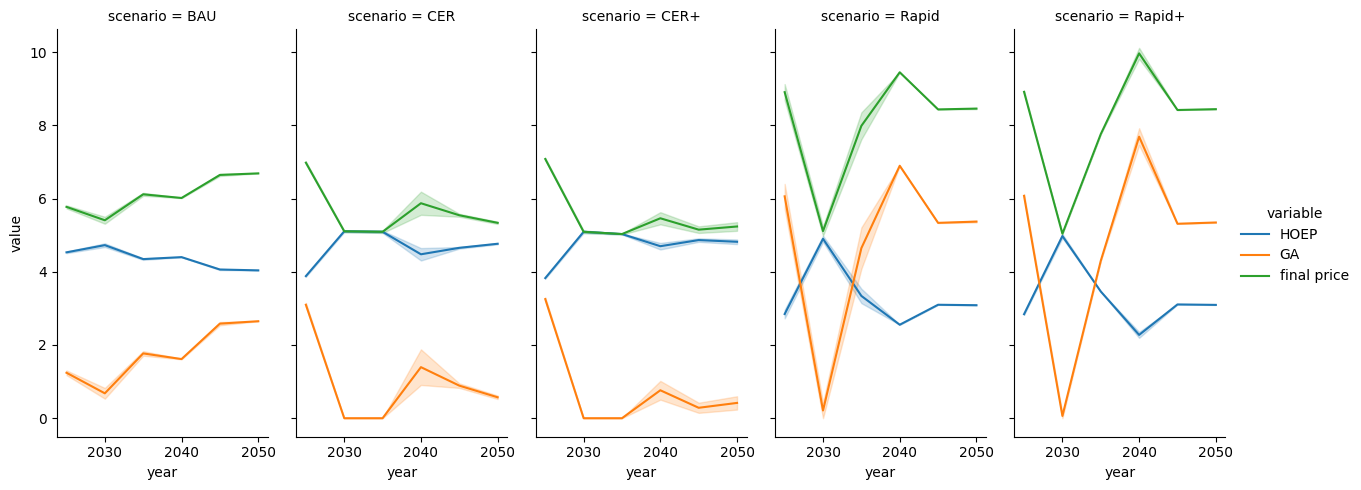

In [26]:
import seaborn as sns
sns.relplot(all_prices, x="year", y="value", hue="variable", col="scenario", kind="line", height=5, aspect=0.5)